In [3]:
%pylab inline
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split #to split in train and test set
from sklearn.linear_model import LogisticRegression #logistic regression classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score #BONUS: to tune parameters using cross-validation
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [46]:
#Data is a bunch of columns with different features.
#1 - month
#3 - day of the week
#4 - airline
#7 - departure airport
#9 - departure time
#17 - distance
#and target:
#22 - arrival delay time || 0 => no relevant delay; 1 => some delay; 2 => major delay

my_data = pd.read_csv('selectedsmalldataset.csv', usecols=[1,3,4,7,9,17,22])

# randomizes data
my_data = my_data.sample(frac=1)

# Create a set of dummy variables from the variable. 
# They say all over the internets that this is how you're supposed to handle categorical vars like strings etc.
df_dummies = pd.get_dummies(my_data.iloc[:,[2,3]])

#convert hours and minutes to just hours
for index, row in my_data.iterrows():
    hour = math.floor(int(row[5])/100)
    minutes = int(row[5])/100 - hour
    if minutes < .3:
        row[5] = hour
    else:
        row[5] = hour + 1

#get values for the target (delay on arrival)
yVal = np.array(my_data.iloc[:,[6]]).reshape(shape(my_data)[0],)
y = []

#delay has 4 values: on time (0), slight delay (1), medium delay (2) significant delay (3)
for value in yVal:
    if value <=5:
        tgt = 0
    elif value <= 45:
        tgt = 1        
    else: 
        tgt = 2
    y.append(tgt)


#remove targets and columns that were converted into dummy variables
my_data = my_data.drop(my_data.columns[[2, 3, 6]], axis=1)

#concat my_data and dummies and generate a np.ndarray of features
df_new = pd.concat([my_data, df_dummies], axis=1)
X = df_new.values

# Scale X
X = preprocessing.scale(X)

#split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)


/Users/konradkrawczyk/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [47]:
print(shape(X))

(71787, 189)


------------------------RANDOM FOREST:------------------------

Cross-Validation: means & stds for given

Best score: 3

Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.81      0.60      0.69     18484
          1       0.24      0.19      0.22      4821
          2       0.13      0.54      0.21      1821

avg / total       0.65      0.52      0.56     25126


Confusion matrix for the best c-parameter (test set):
[[11039  2605  4840]
 [ 1961   926  1934]
 [  576   258   987]]


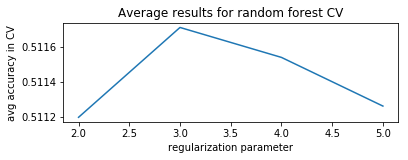

In [53]:
def forest():
    
    #prepare c-values for cross validation
    cVal = [2, 3, 4, 5]
    
    print('------------------------RANDOM FOREST:------------------------')
    print('');
    print('Cross-Validation: means & stds for given');
    #define the classifier
    cv_forestClass = RandomForestClassifier(class_weight="balanced", n_estimators=80, max_features=0.3, max_depth=8)
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_forest = GridSearchCV(estimator=cv_forestClass, param_grid = dict(min_samples_split=cVal), cv=10, scoring='accuracy')
    #fit the data
    cv_forest.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_forest = cv_forest.cv_results_['mean_test_score']
    stds_cv_forest = cv_forest.cv_results_['std_test_score']
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for random forest CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(cVal, means_cv_forest)
    print()
    
    #get the best c-value from grid search
    best = cv_forest.best_params_['min_samples_split']
    #define logistic regression using the best value
    cv_forestBest = RandomForestClassifier(min_samples_split=best, class_weight="balanced", n_estimators=80, max_features=0.3, max_depth=8)
    #fit the training data
    cv_forestBest.fit(X_train, y_train)
    #get the estimates
    predicted = cv_forestBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predicted))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predicted))
    
forest()

------------------------LOGISTIC REGRESSION:------------------------

Cross-Validation: means & stds for given c-values

Best score: 0.0001

Classification report for the best c-parameter (train set):
             precision    recall  f1-score   support

          0       0.80      0.95      0.87     45408
          1       0.21      0.01      0.03      6063
          2       0.20      0.10      0.13      5958

avg / total       0.68      0.76      0.70     57429


Confusion matrix for the best c-parameter (test set):
[[43225   263  1920]
 [ 5570    90   403]
 [ 5287    73   598]]

Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.80      0.95      0.87     11315
          1       0.23      0.01      0.03      1527
          2       0.22      0.11      0.15      1516

avg / total       0.68      0.76      0.70     14358


Confusion matrix for the best c-parameter (test set):
[[10771    50   494]
 [ 1400 

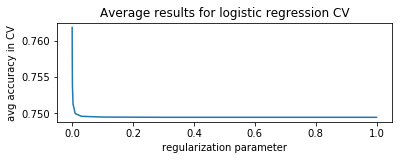

In [57]:
def logRegr():
    
    #prepare c-values for cross validation
    cVal = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5, 1.]
    
    print('------------------------LOGISTIC REGRESSION:------------------------')
    print('');
    print('Cross-Validation: means & stds for given c-values');
    #define the classifier
    cv_regClass = LogisticRegression(class_weight="balanced")
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_reg = GridSearchCV(estimator=cv_regClass, param_grid = dict(C=cVal), cv=10, scoring='accuracy')
    #fit the data
    cv_reg.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_reg = cv_reg.cv_results_['mean_test_score']
    stds_cv_reg = cv_reg.cv_results_['std_test_score']
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for logistic regression CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(cVal, means_cv_reg)
    print()
    
    #get the best c-value from grid search
    best = cv_reg.best_params_['C']
    #define logistic regression using the best value
    cv_regBest = LogisticRegression(C=best, class_weight="balanced")
    #fit the training data
    cv_regBest.fit(X_train, y_train)
    #get the estimates
    predictedtrain = cv_regBest.predict(X_train)
    predictedtest = cv_regBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (train set):')
    print(classification_report(y_train, predictedtrain))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_train, predictedtrain))
    print()
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predictedtest))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predictedtest))
    
logRegr()

------------------------NEURAL NETWORK:------------------------

Cross-Validation: means & stds for given

Best score: (10, 10, 10)

Classification report for the best c-parameter (train set):
             precision    recall  f1-score   support

          0       0.73      1.00      0.85     34166
          1       0.46      0.00      0.01      9169
          2       0.00      0.00      0.00      3326

avg / total       0.63      0.73      0.62     46661


Confusion matrix for the best c-parameter (train set):
[[34125    41     0]
 [ 9129    40     0]
 [ 3320     6     0]]
Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.74      1.00      0.85     18484
          1       0.26      0.00      0.00      4821
          2       0.00      0.00      0.00      1821

avg / total       0.59      0.73      0.62     25126


Confusion matrix for the best c-parameter (test set):


/Users/konradkrawczyk/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[18452    32     0]
 [ 4809    12     0]
 [ 1819     2     0]]


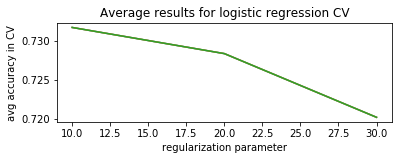

In [54]:
def mlp():
    

    #prepare c-values for cross validation
    hidden = [(10,10,10), (20,20,20), (30,30,30)] # NOTE (2,) is a single layer with 2 nodes
    
    print('------------------------NEURAL NETWORK:------------------------')
    print('');
    print('Cross-Validation: means & stds for given');
    #define the classifier
    cv_mlpClass = MLPClassifier()
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_mlp = GridSearchCV(estimator=cv_mlpClass, param_grid = dict(hidden_layer_sizes=hidden), cv=10, scoring='accuracy')
    #fit the data
    cv_mlp.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_mlp = cv_mlp.cv_results_['mean_test_score']
    stds_cv_mlp = cv_mlp.cv_results_['std_test_score']
    #for mean, std, params in zip(means_cv_reg, stds_cv_reg, cv_reg.cv_results_['params']):
        #print("Mean: %0.5f | Standard Deviation:(+/-%0.03f) | for %r" % (mean, std * 2, params))
    #print()
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for logistic regression CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(hidden, means_cv_mlp)
    print()
    
    #get the best c-value from grid search
    best = cv_mlp.best_params_['hidden_layer_sizes']
    #define logistic regression using the best value
    cv_mlpBest = MLPClassifier(hidden_layer_sizes=best)
    #fit the training data
    cv_mlpBest.fit(X_train, y_train)
    #get the estimates
    predictedtrain = cv_mlpBest.predict(X_train)
    predictedtest = cv_mlpBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (train set):')
    print(classification_report(y_train, predictedtrain))
    print()
    print('Confusion matrix for the best c-parameter (train set):')
    print(metrics.confusion_matrix(y_train, predictedtrain))
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predictedtest))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predictedtest))
    
mlp()

In [45]:
def mlp():
        
    print('------------------------NEURAL NETWORK:------------------------')
    print('');

    #define logistic regression using the best value
    cv_mlpBest = MLPClassifier(hidden_layer_sizes=(30,30,30), solver='adam', alpha=1e-4)  #fit the training data
    cv_mlpBest.fit(X_train, y_train)
    #get the estimates
    predictedtrain = cv_mlpBest.predict(X_train)
    print(metrics.confusion_matrix(y_train, predictedtrain))
    print(classification_report(y_train, predictedtrain))
    predictedtest = cv_mlpBest.predict(X_test)
    print(metrics.confusion_matrix(y_test, predictedtest))
    print(classification_report(y_test, predictedtest))
mlp()

------------------------NEURAL NETWORK:------------------------

[[166930   1163    499]
 [ 49854   1568    483]
 [ 24424    809    974]]
             precision    recall  f1-score   support

          0       0.69      0.99      0.81    168592
          1       0.44      0.03      0.06     51905
          2       0.50      0.04      0.07     26207

avg / total       0.62      0.69      0.58    246704

[[89479   854   365]
 [27213   668   218]
 [13290   379   375]]
             precision    recall  f1-score   support

          0       0.69      0.99      0.81     90698
          1       0.35      0.02      0.04     28099
          2       0.39      0.03      0.05     14044

avg / total       0.59      0.68      0.57    132841



In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_reg = RandomForestClassifier(min_samples_split=2, class_weight="balanced", n_estimators=50, max_features=0.3, max_depth=8)
forest_reg.fit(X_train,y_train)

In [ ]:
print(metrics.confusion_matrix(y_train,(forest_reg.predict(X_train))))
print(classification_report(y_train,(forest_reg.predict(X_train))))

In [ ]:
print(metrics.confusion_matrix(y_test,(forest_reg.predict(X_test))))
print(classification_report(y_test,(forest_reg.predict(X_test))))